In [1]:
%%capture
!pip install rdkit

In [2]:
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import optuna
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors, MACCSkeys, RDKFingerprint, rdFingerprintGenerator
from rdkit.Chem.AtomPairs import Pairs, Torsions

# DISABLE WARNING FROM rdkit
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

try:
    from rdkit.Avalon import pyAvalonTools
    avalon_available = True
except ImportError:
    avalon_available = False

import plotly.io as pio
pio.renderers.default = "iframe_connected"

from IPython.display import clear_output

import xgboost

In [3]:
# LOAD DATA

train_df = pd.read_csv(r'C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Thermophysical properties prediction/train.csv')
test_df = pd.read_csv(r'C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Thermophysical properties prediction/test.csv')
bradley_df = pd.read_excel(r'C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Thermophysical properties prediction/BradleyMeltingPointDataset.xlsx')
bradleyplus_df = pd.read_excel(r'C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Thermophysical properties prediction/BradleyDoublePlusGoodMeltingPointDataset.xlsx')


train_df = train_df[['SMILES', 'Tm']]
test_df  = test_df[['id', 'SMILES']]

train_df.shape, test_df.shape, bradley_df.shape, bradleyplus_df.shape

((2662, 2), (666, 2), (28645, 9), (3041, 11))

In [4]:
display(train_df)
display(test_df)

SMILES      Tm
0           FC1=C(F)C(F)(F)C1(F)F  213.15
1     c1ccc2c(c1)ccc3Nc4ccccc4c23  407.15
2             CCN1C(C)=Nc2ccccc12  324.15
3                      CC#CC(=O)O  351.15
4                       CCCCC(S)C  126.15
...                           ...     ...
2657                       ClCCBr  256.45
2658               N#CC(Cl)(Cl)Cl  231.15
2659           Cc1ccc2c(C)cccc2c1  256.25
2660        CCC(=O)c1ccc2ccccc2c1  333.15
2661            Brc1ccc(cc1)N(C)C  328.15

[2662 rows x 2 columns]

id                SMILES
0    1022   CCOC(=O)c1ccc(O)cc1
1    1146    CCCCCCc1ccc(O)cc1O
2      79                 ClCBr
3    2279           C=CCCCCCCCC
4    1342   Fc1ccc(cc1)C(F)(F)F
..    ...                   ...
661  2663       CCCCCCCCC(=O)CC
662   624  COc1ccc(COC(=O)C)cc1
663  2655            C#CCCC(C)C
664  2089        BrCC(Br)C(Br)C
665  1065          OCCCc1ccccc1

[666 rows x 2 columns]

In [5]:
# CONVERT MELTING POINT CELCIUS TO KELVIN (Tm)

bradley_df['Tm'] = bradley_df['mpC'].map(lambda x : x + 273.15)
bradleyplus_df['Tm'] = bradleyplus_df['mpC'].map(lambda x: x + 273.15)

# GET ONLY SMILES AND Tm COLUMNS
bradley_df = bradley_df[['smiles', 'Tm']]
bradleyplus_df = bradleyplus_df[['smiles', 'Tm']]

# MERGE THEM
bradley_merge = pd.concat((bradley_df, bradleyplus_df), axis = 0)
bradley_merge = bradley_merge.rename(columns = {'smiles' : 'SMILES'})

bradley_merge

SMILES      Tm
0         c1ccnc(c1)Cc2ccc(cc2[N+](=O)[O-])[N+](=O)[O-]  365.15
1                                 c1ccc(c(c1)N)N2CCCCC2  319.15
2                                    c1cnc(nc1)N2CCNCC2  306.15
3                                 c1ccc(c(c1)N2CCNCC2)O  398.15
4                                        C1CCC(=CC1)CCN  218.15
...                                                 ...     ...
3036                    C1=CC(=CC=C1C(=O)O)[N+](=O)[O-]  513.15
3037             C1CC(=O)NC(=O)C1N2C(=O)C3=CC=CC=C3C2=O  548.15
3038  C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2O)CCC4=C3...  449.15
3039                           C1=C(C=C(C(=C1Cl)O)Cl)Cl  338.15
3040                              c1ccc(c(c1)C(F)(F)F)N  239.15

[31686 rows x 2 columns]

In [6]:
# CONCAT TRAIN DATA AND EXTRA DATA

merge_df = pd.concat((train_df, bradley_merge), axis = 0)

merge_df

SMILES      Tm
0                                 FC1=C(F)C(F)(F)C1(F)F  213.15
1                           c1ccc2c(c1)ccc3Nc4ccccc4c23  407.15
2                                   CCN1C(C)=Nc2ccccc12  324.15
3                                            CC#CC(=O)O  351.15
4                                             CCCCC(S)C  126.15
...                                                 ...     ...
3036                    C1=CC(=CC=C1C(=O)O)[N+](=O)[O-]  513.15
3037             C1CC(=O)NC(=O)C1N2C(=O)C3=CC=CC=C3C2=O  548.15
3038  C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2O)CCC4=C3...  449.15
3039                           C1=C(C=C(C(=C1Cl)O)Cl)Cl  338.15
3040                              c1ccc(c(c1)C(F)(F)F)N  239.15

[34348 rows x 2 columns]

In [7]:
# DROP DUPLICATED FROM MERGED DATA

display(f'There are {merge_df.duplicated(subset = ["SMILES", "Tm"]).sum()} Duplicated data')

merge_df = merge_df.drop_duplicates(subset = ['SMILES', 'Tm']).reset_index(drop = True)

print(f'Successfully Drop Duplicated data!')

merge_df

'There are 5237 Duplicated data'

Successfully Drop Duplicated data!


SMILES      Tm
0                          FC1=C(F)C(F)(F)C1(F)F  213.15
1                    c1ccc2c(c1)ccc3Nc4ccccc4c23  407.15
2                            CCN1C(C)=Nc2ccccc12  324.15
3                                     CC#CC(=O)O  351.15
4                                      CCCCC(S)C  126.15
...                                          ...     ...
29106  CC(=O)CC(C\1=C(/O)c2ccccc2OC/1=O)c3ccccc3  434.65
29107                     c1ccc2c(c1)Cc3ccccc3O2  373.65
29108                     c1ccc2c(c1)Cc3ccccc3O2  374.65
29109                 C1C2=CC=CC=C2OC3=CC=CC=C31  374.15
29110                                  N#C\C=C/C  200.55

[29111 rows x 2 columns]

In [8]:
# EXTRACT ALL DESCRIPTORS FEATURES

def extract_all_descriptors(df, SMILES):

    # GET ALL DESCRIPTORS
    descriptor_list = Descriptors._descList    # --> THESE WILL RETURN LIST OF TUPLE
    descriptors = [desc[0] for desc in descriptor_list]

    print(f'There Are {len(descriptor_list)} Descriptor Features')

    # EXTRACT ALL DESCRIPTORS FROM SMILES FEATURES
    result = []
    for smi in df[SMILES]:

        mol = Chem.MolFromSmiles(smi)

        # IF MOLECOLE IS INVALID
        if mol is None:
            row = {name : None for name, func in descriptor_list}
        else:
            # CREATE DESCRIPTORS FEATURES
            row = {name: func(mol) for name, func in descriptor_list}

        result.append(row)

    # MERGE DATA WITH EXTRACTED FEATURES
    df_descriptor = pd.DataFrame(result)
    df_result = pd.concat((df, df_descriptor), axis = 1)

    return df_result


merge_df = extract_all_descriptors(merge_df, 'SMILES')
test_df  = extract_all_descriptors(test_df, 'SMILES')

# DROP NULL/NONE VALUE AFTER FEATURE ENGINEERING
merge_df = merge_df.dropna().reset_index(drop = True)
test_df = test_df.dropna().reset_index(drop = True)

merge_df

There Are 217 Descriptor Features
There Are 217 Descriptor Features


SMILES      Tm  MaxAbsEStateIndex  \
0                          FC1=C(F)C(F)(F)C1(F)F  213.15          11.537037   
1                    c1ccc2c(c1)ccc3Nc4ccccc4c23  407.15           3.470111   
2                            CCN1C(C)=Nc2ccccc12  324.15           4.446898   
3                                     CC#CC(=O)O  351.15           9.425694   
4                                      CCCCC(S)C  126.15           4.232083   
...                                          ...     ...                ...   
28803  CC(=O)CC(C\1=C(/O)c2ccccc2OC/1=O)c3ccccc3  434.65          12.412307   
28804                     c1ccc2c(c1)Cc3ccccc3O2  373.65           5.777407   
28805                     c1ccc2c(c1)Cc3ccccc3O2  374.65           5.777407   
28806                 C1C2=CC=CC=C2OC3=CC=CC=C31  374.15           5.777407   
28807                                  N#C\C=C/C  200.55           7.729444   

       MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0           11.537037           2.668981       -4.947338  0.479530  28.200000   
1            3.470111           1.207271        1.207271  0.446879  11.529412   
2            4.446898           0.992407        0.992407  0.625839  10.833333   
3            9.425694           1.071759       -1.071759  0.422302   5.500000   
4            4.232083           0.597176        0.597176  0.540734  14.142857   
...               ...                ...             ...       ...        ...   
28803       12.412307           0.064063       -0.614534  0.747626  12.217391   
28804        5.777407           0.978519        0.978519  0.517522  12.571429   
28805        5.777407           0.978519        0.978519  0.517522  12.571429   
28806        5.777407           0.978519        0.978519  0.517522  12.571429   
28807        7.729444           1.430556        1.430556  0.388843   8.000000   

         MolWt  HeavyAtomMolWt  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0      162.032         162.032  ...         0.0           0.0         0.0   
1      217.271         206.183  ...         0.0           0.0         0.0   
2      160.220         148.124  ...         0.0           0.0         0.0   
3       84.074          80.042  ...         0.0           0.0         0.0   
4      118.245         104.133  ...         0.0           0.0         0.0   
...        ...             ...  ...         ...           ...         ...   
28803  308.333         292.205  ...         0.0           0.0         0.0   
28804  182.222         172.142  ...         0.0           0.0         0.0   
28805  182.222         172.142  ...         0.0           0.0         0.0   
28806  182.222         172.142  ...         0.0           0.0         0.0   
28807   67.091          62.051  ...         0.0           0.0         0.0   

       fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  \
0                    0.0           0.0          0.0          0.0   
1                    0.0           0.0          0.0          0.0   
2                    0.0           0.0          0.0          0.0   
3                    0.0           0.0          0.0          0.0   
4                    0.0           0.0          0.0          0.0   
...                  ...           ...          ...          ...   
28803                0.0           0.0          0.0          0.0   
28804                0.0           0.0          0.0          0.0   
28805                0.0           0.0          0.0          0.0   
28806                0.0           0.0          0.0          0.0   
28807                0.0           0.0          0.0          0.0   

       fr_thiophene  fr_unbrch_alkane  fr_urea  
0               0.0               0.0      0.0  
1               0.0               0.0      0.0  
2               0.0               0.0      0.0  
3               0.0               0.0      0.0  
4               0.0               1.0      0.0  
...             ...               ...      ...  
28803           0.0               0

In [9]:
# EXTRACT ALL MOLECULAR FINGERPRINT FEATURES

def extract_all_fingerprint(df, SMILES, morgan_radius = 2, morgan_nbits = 1024):

    fps_data = []  # --> STORE NEW FEATURES DATA

    # DEFINE MORGAN GENERATOR
    morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius = morgan_radius, fpSize = morgan_nbits, countSimulation = True, includeChirality = False)

    fcfp = rdFingerprintGenerator.GetMorganFeatureAtomInvGen()
    fcfp_gen = rdFingerprintGenerator.GetMorganGenerator(radius = morgan_nbits, fpSize = morgan_nbits, atomInvariantsGenerator = fcfp, countSimulation= True, includeChirality = False)

    atom_gen = rdFingerprintGenerator.GetAtomPairGenerator(fpSize = 2048, countSimulation= True, includeChirality = False)

    # ITERATE EVERY SAMPLE OF SMILES FEATURES
    for smiles in df[SMILES]:
        mol = Chem.MolFromSmiles(smiles)

        if mol is None:
            print(smiles, 'is Invalid!')
            fps_data.append({})
            continue

        # STORE NEW FEATURE FOR EACH SAMPLES CREATED
        feature_rows = {}

        # MORGAN FINGERPRINT (ECFP)
        morgan_fp = morgan_gen.GetFingerprint(mol)
        for i in range(morgan_nbits):
            feature_rows[f"Morgan_{i}"] = morgan_fp[i]

        # FUNCTIONAL-CLASS FINGERPRINT (FCFP)
        fc_fp = fcfp_gen.GetFingerprint(mol)
        for i in range(morgan_nbits):
            feature_rows[f"FCFP_{i}"] = fc_fp[i]

        # MACCS KEYS (166 BITS)
        maccs_fp = MACCSkeys.GenMACCSKeys(mol)
        for i in range(len(maccs_fp)):
            feature_rows[f"MACCS_{i}"] = int(maccs_fp[i])

        # AtomPair Fingerprint (2D)
        atompair_fp = atom_gen.GetCountFingerprint(mol)
        for i in range(morgan_nbits):
            feature_rows[f"AtomPair_{i}"] = atompair_fp[i]

        # RDKIT FINGERPRINT
        rdkit_fp = RDKFingerprint(mol)
        for i in range(len(rdkit_fp)):
            feature_rows[f"RDKIT_{i}"] = int(rdkit_fp[i])

        # AVALON FINGERPRINT (IF AVAILABLE) 
        if avalon_available:
            avalon_fp = pyAvalonTools.GetAvalonFP(mol, morgan_nbits)
        for i in range(len(avalon_fp)):
            feature_rows[f"Avalon_{i}"] = int(avalon_fp[i])


        fps_data.append(feature_rows)

    print(f'There are {morgan_nbits} Morgan Fingerprint Features')
    print(f'There are {len(maccs_fp)} MACCS Keys Features')
    print(f'There are {len(rdkit_fp)} RDKIT Fingerprint Features')

    # MERGE REAL DATA WITH EXTRACTED FEATURES
    fps_df = pd.DataFrame(fps_data)
    df_result = pd.concat((df, fps_df), axis = 1)

    return df_result


# APPLY FUNCTION
merge_df = extract_all_fingerprint(merge_df, 'SMILES')
test_df  = extract_all_fingerprint(test_df, 'SMILES')

merge_df

There are 1024 Morgan Fingerprint Features
There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
There are 1024 Morgan Fingerprint Features
There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features


SMILES      Tm  MaxAbsEStateIndex  \
0                          FC1=C(F)C(F)(F)C1(F)F  213.15          11.537037   
1                    c1ccc2c(c1)ccc3Nc4ccccc4c23  407.15           3.470111   
2                            CCN1C(C)=Nc2ccccc12  324.15           4.446898   
3                                     CC#CC(=O)O  351.15           9.425694   
4                                      CCCCC(S)C  126.15           4.232083   
...                                          ...     ...                ...   
28803  CC(=O)CC(C\1=C(/O)c2ccccc2OC/1=O)c3ccccc3  434.65          12.412307   
28804                     c1ccc2c(c1)Cc3ccccc3O2  373.65           5.777407   
28805                     c1ccc2c(c1)Cc3ccccc3O2  374.65           5.777407   
28806                 C1C2=CC=CC=C2OC3=CC=CC=C31  374.15           5.777407   
28807                                  N#C\C=C/C  200.55           7.729444   

       MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0           11.537037           2.668981       -4.947338  0.479530  28.200000   
1            3.470111           1.207271        1.207271  0.446879  11.529412   
2            4.446898           0.992407        0.992407  0.625839  10.833333   
3            9.425694           1.071759       -1.071759  0.422302   5.500000   
4            4.232083           0.597176        0.597176  0.540734  14.142857   
...               ...                ...             ...       ...        ...   
28803       12.412307           0.064063       -0.614534  0.747626  12.217391   
28804        5.777407           0.978519        0.978519  0.517522  12.571429   
28805        5.777407           0.978519        0.978519  0.517522  12.571429   
28806        5.777407           0.978519        0.978519  0.517522  12.571429   
28807        7.729444           1.430556        1.430556  0.388843   8.000000   

         MolWt  HeavyAtomMolWt  ...  Avalon_1014  Avalon_1015  Avalon_1016  \
0      162.032         162.032  ...            0            0            0   
1      217.271         206.183  ...            1            0            0   
2      160.220         148.124  ...            0            0            1   
3       84.074          80.042  ...            0            0            0   
4      118.245         104.133  ...            0            0            0   
...        ...             ...  ...          ...          ...          ...   
28803  308.333         292.205  ...            1            0            1   
28804  182.222         172.142  ...            0            0            0   
28805  182.222         172.142  ...            0            0            0   
28806  182.222         172.142  ...            0            0            0   
28807   67.091          62.051  ...            0            0            0   

       Avalon_1017  Avalon_1018  Avalon_1019  Avalon_1020  Avalon_1021  \
0                0            0            0            1            0   
1                0            0            0            0            0   
2                0            0            1            0            0   
3                0            0            0            0            0   
4                0            0            0            0            0   
...            ...          ...          ...          ...          ...   
28803            0            0            0            0            0   
28804            0            0            0            0            0   
28805            0            0            0            0            0   
28806            0            0            0            0            0   
28807            1            0            0            0            0   

       Avalon_1022  Avalon_1023  
0                0            0  
1                0            0  
2                1            1  
3                0            0  
4                0            0  
...            ...          ...  
28803            1            1  
28804            0    

In [10]:
# SPLIT DATA

x = merge_df.drop(labels = ['SMILES', 'Tm'], axis = 1)
y = merge_df['Tm']

x_test = test_df.drop(labels = ['SMILES', 'id'], axis = 1)

x.shape, y.shape, x_test.shape, type(x)

((28808, 6528), (28808,), (666, 6528), pandas.core.frame.DataFrame)

In [11]:
def objective(trial):
    
    xgb_params = {
        "verbosity": 0,
        "objective": trial.suggest_categorical("objective", ['reg:squarederror', 'reg:pseudohubererror']),
        "tree_method": "gpu_hist",
        'predictor' : 'gpu_predictor',
        'device' : 'cuda',
        "eval_metric": "rmse",
        "booster": "gbtree",
        'n_estimators' : 10_000,
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "learning_rate": trial.suggest_float("learning_rate", 3e-3, 0.3, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 0.1, 20.0, log=True),
        "alpha": trial.suggest_float("alpha", 0.1, 20.0, log=True),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state = 2025)
    rmse_scores = []

    for train_idx, valid_idx in kf.split(x):
        X_train, X_valid = x.iloc[train_idx], x.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        dtrain = xgboost.DMatrix(X_train, label=y_train)
        dvalid = xgboost.DMatrix(X_valid, label=y_valid)

        model = xgboost.train(
            xgb_params,
            dtrain,
            num_boost_round=10000,
            evals=[(dvalid, "validation")],
            early_stopping_rounds=100,
            verbose_eval=False,
        )

        preds = model.predict(dvalid)
        rmse = mean_squared_error(y_valid, preds, squared = False)
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

In [ ]:
# START OPTUNA

# MOVE AND COPY FILE TO OUPUT
shutil.copy(src = '/kaggle/input/optuna-study-3-models/other/optuna-study-3-models/2/xgb_study.db', 
            dst = '/kaggle/working/xgb_study.db')

study = optuna.create_study(direction="minimize", study_name = 'xgb_study', 
                            storage="sqlite://////kaggle/working/xgb_study.db", 
                            load_if_exists = True)

# CLEAR OUTPUT AFTER TRAINING 
clear_output(wait=True)

print(f'Training Complete! Congrats!')
print(f'Total Number of Trials : {len(study.trials)}\n')

print("Best Trial", study.best_trial.number)
print("Best MAE:", study.best_value)
print("Best Params:", study.best_trial.params)

In [14]:
# TRAIN XGB WITH BEST PARAMETERS

#best_params = study.best_trial.params
#best_params.update({'eval_metric' : "mae",
#                    'device' : 'cpu'})

# USE SIMPLER MODEL THAN TUNED MODEL (DUE TO SLOW COMPUTATION)
best_params = {
    'max_depth' : 6,
    'eta' : 0.1,
    'tree_method' : 'hist',
    'eval_metric' : 'mae'
}

best_params

{'max_depth': 6, 'eta': 0.1, 'tree_method': 'hist', 'eval_metric': 'mae'}

Selected features: 3075 

[0]	train-mae:0.74343	valid-mae:0.74527
[1000]	train-mae:0.08218	valid-mae:0.20504
[2000]	train-mae:0.04385	valid-mae:0.19140
[3000]	train-mae:0.03049	valid-mae:0.18649
[4000]	train-mae:0.02517	valid-mae:0.18465
[5000]	train-mae:0.02288	valid-mae:0.18406
[6000]	train-mae:0.02184	valid-mae:0.18377
[6383]	train-mae:0.02179	valid-mae:0.18376


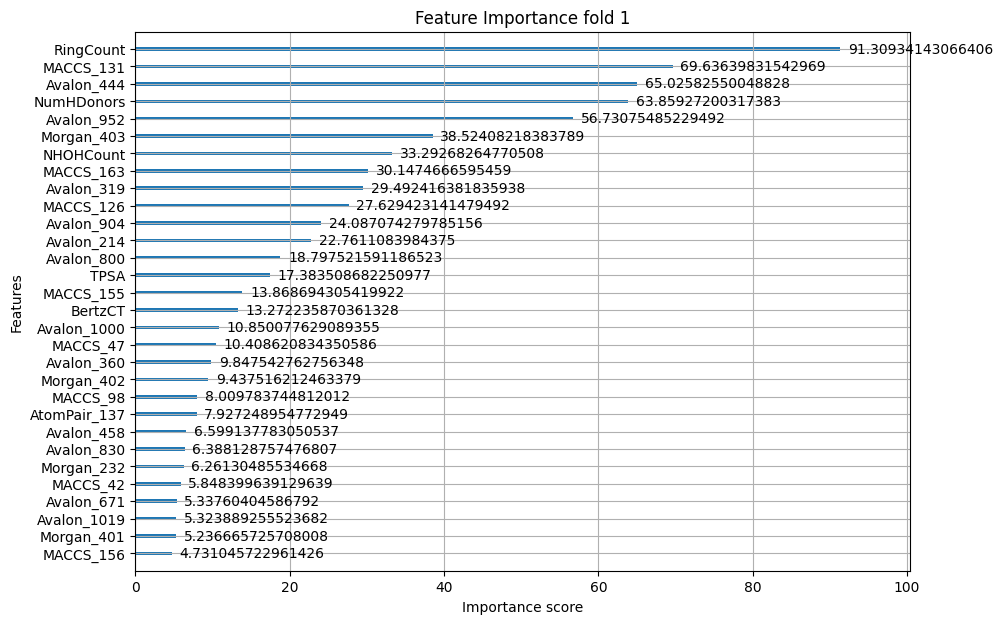

Fold 1 : Train MAE = 2.138560110170065, Val MAE = 17.853881746429153
Selected features: 3079 

[0]	train-mae:0.74453	valid-mae:0.75107
[1000]	train-mae:0.08286	valid-mae:0.20503
[2000]	train-mae:0.04433	valid-mae:0.19053
[3000]	train-mae:0.03120	valid-mae:0.18534
[4000]	train-mae:0.02613	valid-mae:0.18339
[5000]	train-mae:0.02401	valid-mae:0.18278
[6000]	train-mae:0.02305	valid-mae:0.18256
[6312]	train-mae:0.02303	valid-mae:0.18255


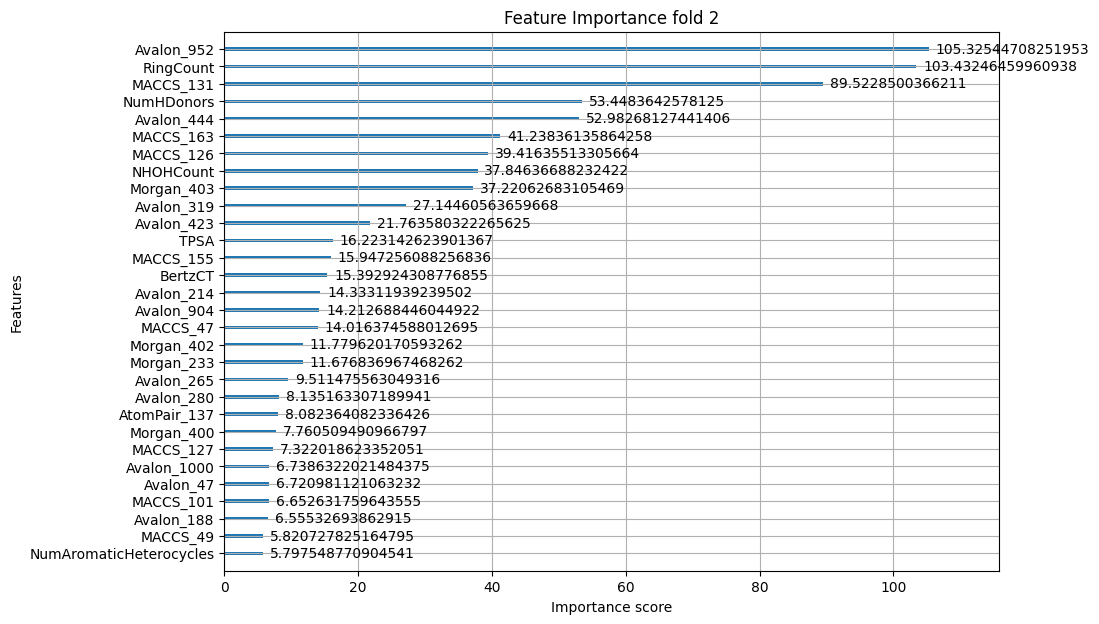

Fold 2 : Train MAE = 2.2573787692475302, Val MAE = 17.69670691625561
Selected features: 3065 

[0]	train-mae:0.74415	valid-mae:0.74823
[1000]	train-mae:0.08263	valid-mae:0.21049
[2000]	train-mae:0.04424	valid-mae:0.19448
[3000]	train-mae:0.03098	valid-mae:0.18903
[4000]	train-mae:0.02565	valid-mae:0.18705
[5000]	train-mae:0.02335	valid-mae:0.18636
[6000]	train-mae:0.02231	valid-mae:0.18609
[6376]	train-mae:0.02227	valid-mae:0.18608


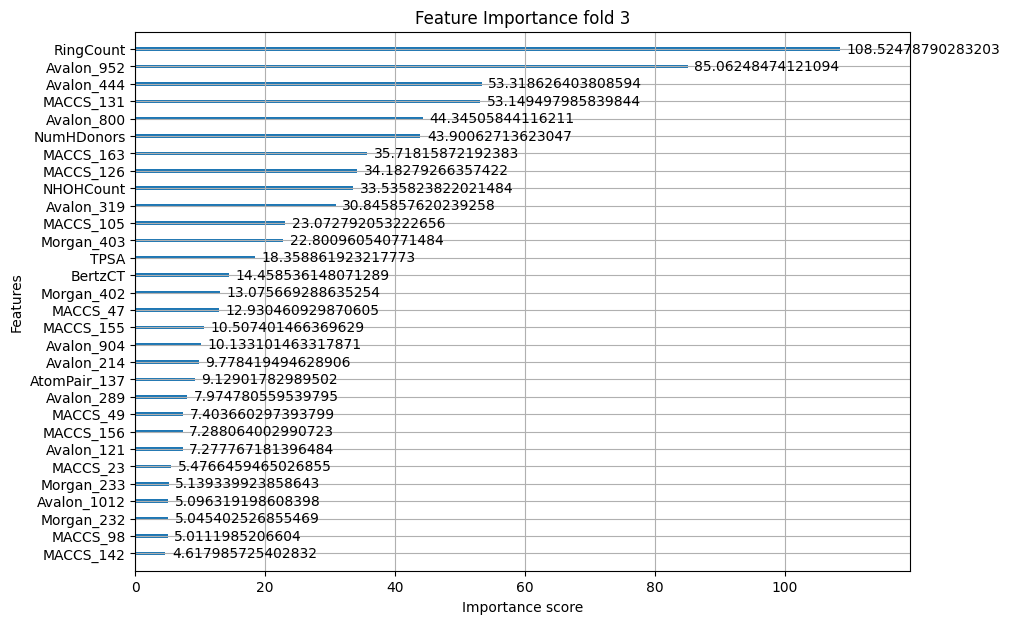

Fold 3 : Train MAE = 2.1832280719518864, Val MAE = 18.082556786740746
Selected features: 3061 

[0]	train-mae:0.74360	valid-mae:0.74507
[1000]	train-mae:0.08134	valid-mae:0.21356
[2000]	train-mae:0.04330	valid-mae:0.19906
[3000]	train-mae:0.03047	valid-mae:0.19437
[4000]	train-mae:0.02522	valid-mae:0.19257
[5000]	train-mae:0.02302	valid-mae:0.19185
[6000]	train-mae:0.02206	valid-mae:0.19162
[6304]	train-mae:0.02206	valid-mae:0.19162


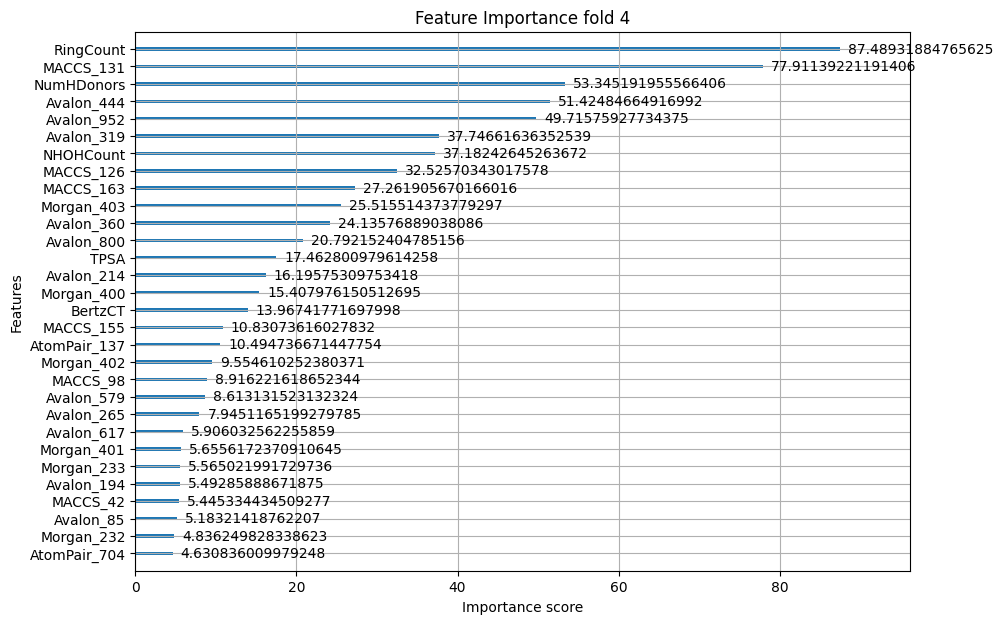

Fold 4 : Train MAE = 2.163045796473691, Val MAE = 18.660796006589006
Selected features: 3067 

[0]	train-mae:0.74376	valid-mae:0.74213
[1000]	train-mae:0.08214	valid-mae:0.20683
[2000]	train-mae:0.04378	valid-mae:0.19311
[3000]	train-mae:0.03053	valid-mae:0.18827
[4000]	train-mae:0.02537	valid-mae:0.18653
[5000]	train-mae:0.02317	valid-mae:0.18589
[6000]	train-mae:0.02221	valid-mae:0.18568
[6252]	train-mae:0.02221	valid-mae:0.18568


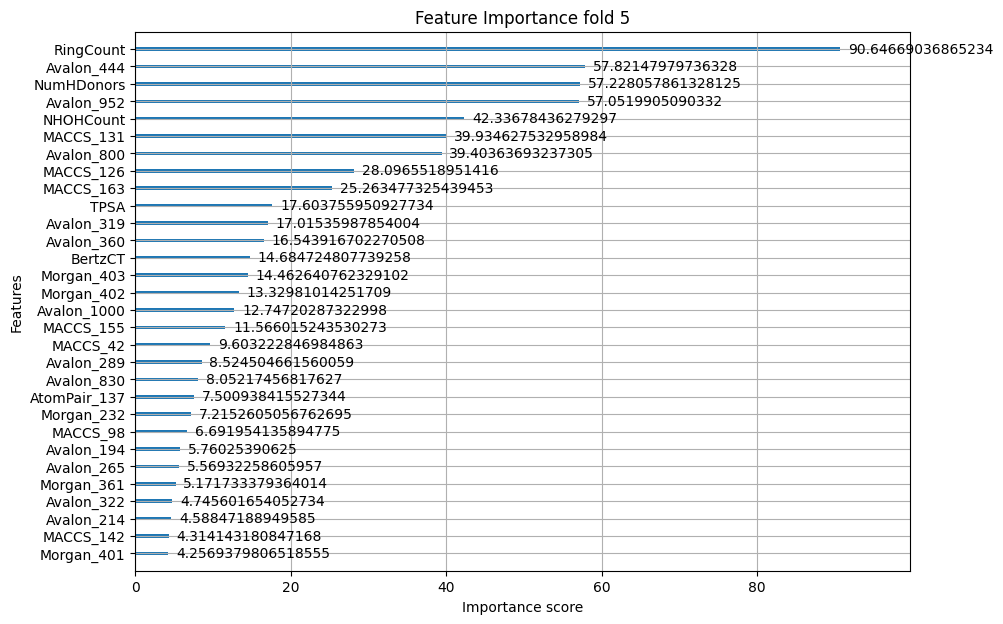

Fold 5 : Train MAE = 2.180023840923624, Val MAE = 18.045606875778773
Selected features: 3098 

[0]	train-mae:0.74436	valid-mae:0.74403
[1000]	train-mae:0.08469	valid-mae:0.20363
[2000]	train-mae:0.04611	valid-mae:0.18819
[3000]	train-mae:0.03237	valid-mae:0.18251
[4000]	train-mae:0.02670	valid-mae:0.18031
[5000]	train-mae:0.02429	valid-mae:0.17945
[6000]	train-mae:0.02318	valid-mae:0.17913
[6481]	train-mae:0.02305	valid-mae:0.17909


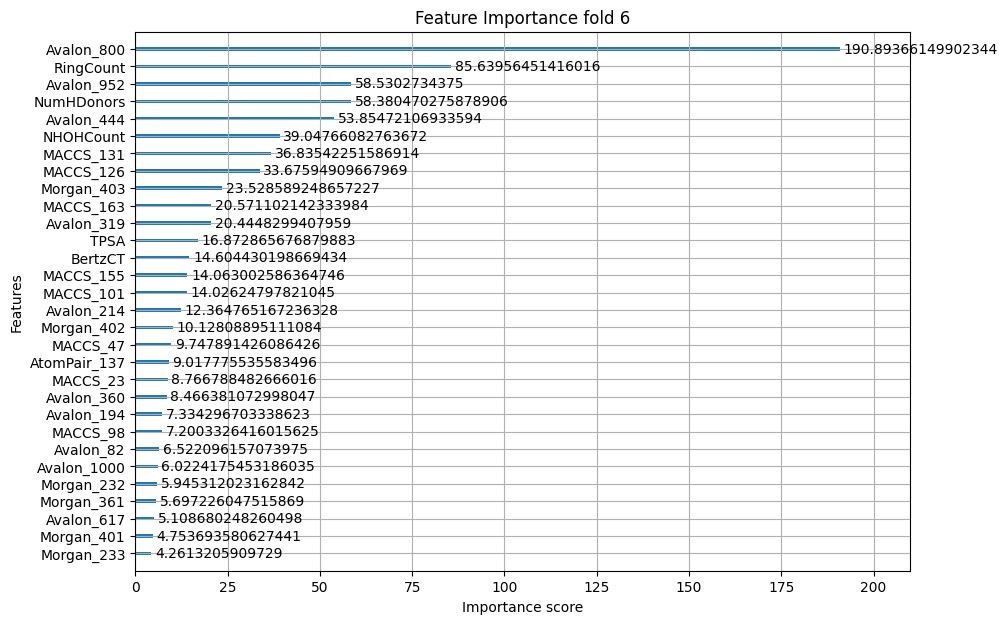

Fold 6 : Train MAE = 2.261568368068748, Val MAE = 17.381757272589912
Selected features: 3091 

[0]	train-mae:0.74380	valid-mae:0.73867
[1000]	train-mae:0.08193	valid-mae:0.19808
[2000]	train-mae:0.04346	valid-mae:0.18401
[3000]	train-mae:0.03032	valid-mae:0.17940
[4000]	train-mae:0.02512	valid-mae:0.17760
[5000]	train-mae:0.02294	valid-mae:0.17696
[6000]	train-mae:0.02200	valid-mae:0.17672
[7000]	train-mae:0.02200	valid-mae:0.17672
[8000]	train-mae:0.02200	valid-mae:0.17672
[9000]	train-mae:0.02200	valid-mae:0.17672
[10000]	train-mae:0.02200	valid-mae:0.17672
[11000]	train-mae:0.02200	valid-mae:0.17672
[12000]	train-mae:0.02200	valid-mae:0.17672
[13000]	train-mae:0.02200	valid-mae:0.17672
[14000]	train-mae:0.02200	valid-mae:0.17672
[14999]	train-mae:0.02200	valid-mae:0.17672


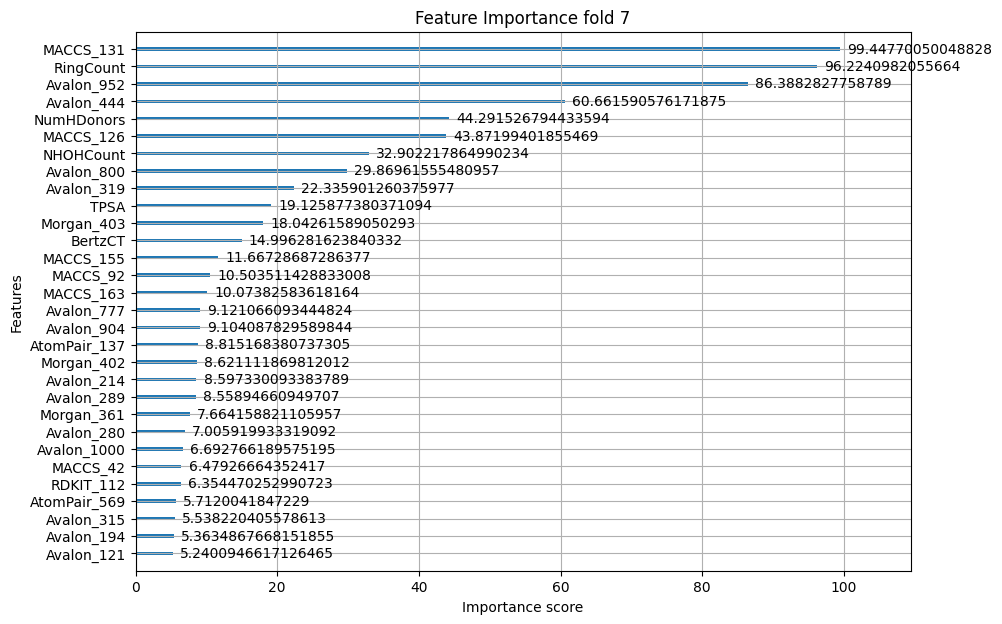

Fold 7 : Train MAE = 2.160535681933439, Val MAE = 17.177973776873266
Selected features: 3083 

[0]	train-mae:0.74400	valid-mae:0.74230
[1000]	train-mae:0.08313	valid-mae:0.19981
[2000]	train-mae:0.04481	valid-mae:0.18332
[3000]	train-mae:0.03092	valid-mae:0.17724
[4000]	train-mae:0.02558	valid-mae:0.17509
[5000]	train-mae:0.02321	valid-mae:0.17428
[6000]	train-mae:0.02214	valid-mae:0.17396
[6342]	train-mae:0.02210	valid-mae:0.17395


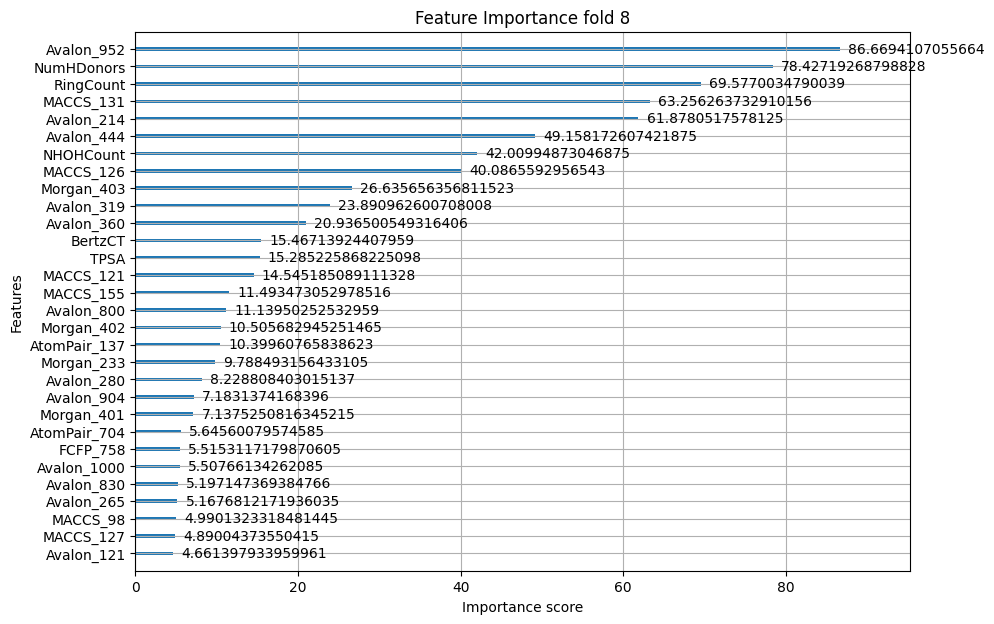

Fold 8 : Train MAE = 2.170591394122302, Val MAE = 16.91266662173948
Selected features: 3099 

[0]	train-mae:0.74400	valid-mae:0.75122
[1000]	train-mae:0.08103	valid-mae:0.21030
[2000]	train-mae:0.04272	valid-mae:0.19638
[3000]	train-mae:0.03003	valid-mae:0.19116
[4000]	train-mae:0.02492	valid-mae:0.18915
[5000]	train-mae:0.02273	valid-mae:0.18835
[6000]	train-mae:0.02177	valid-mae:0.18803
[6284]	train-mae:0.02177	valid-mae:0.18803


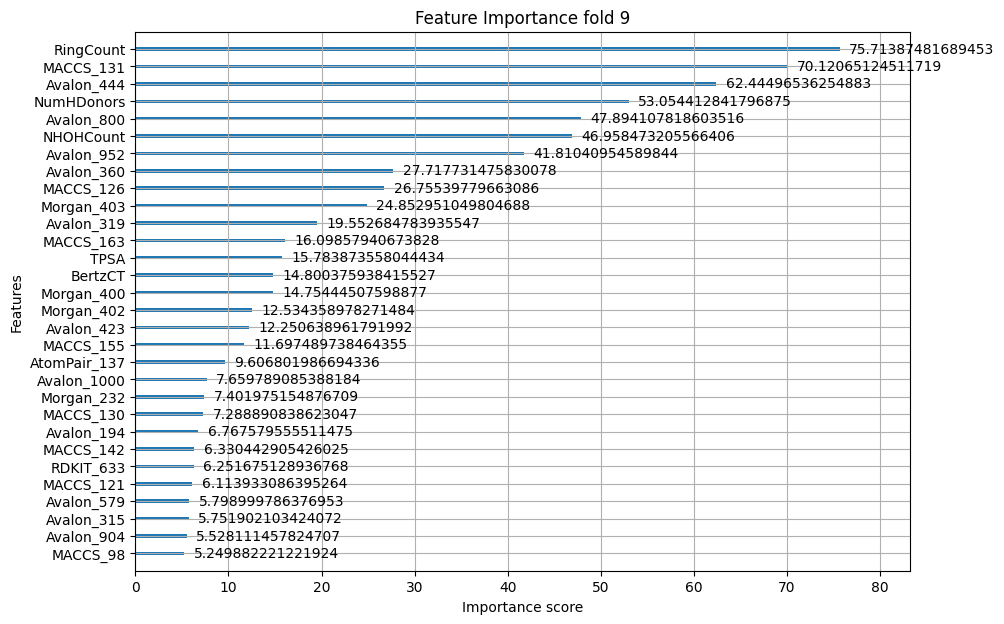

Fold 9 : Train MAE = 2.137409543005344, Val MAE = 18.235452327622312
Selected features: 2994 

[0]	train-mae:0.74383	valid-mae:0.73798
[1000]	train-mae:0.08260	valid-mae:0.20089
[2000]	train-mae:0.04449	valid-mae:0.18627
[3000]	train-mae:0.03104	valid-mae:0.18070
[4000]	train-mae:0.02575	valid-mae:0.17879
[5000]	train-mae:0.02351	valid-mae:0.17808
[6000]	train-mae:0.02253	valid-mae:0.17780
[6268]	train-mae:0.02253	valid-mae:0.17780


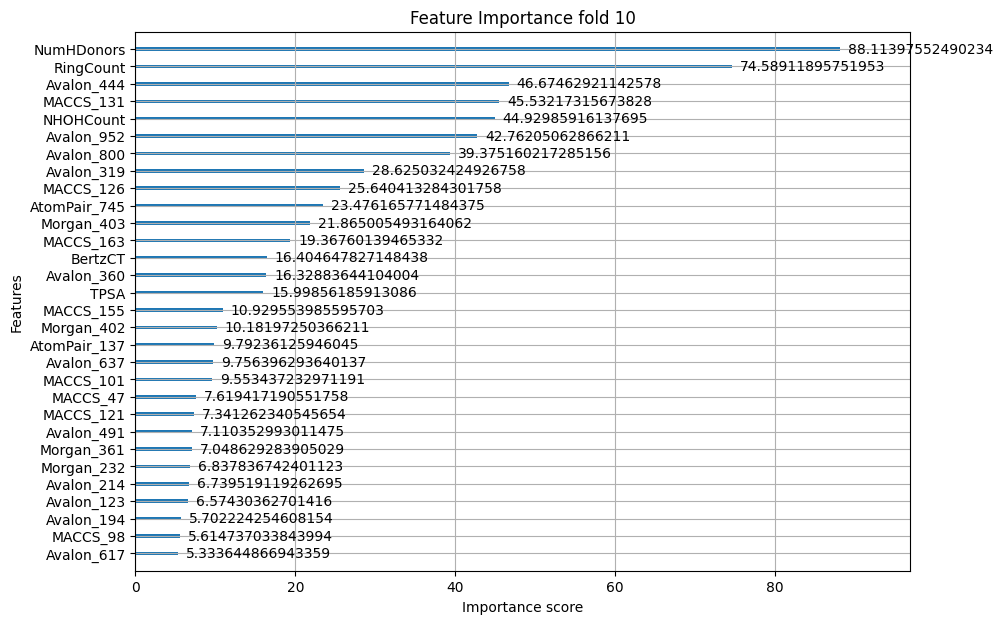

Fold 10 : Train MAE = 2.2132678542568214, Val MAE = 17.303868448893226

Train Fold Prediction : 2.186560943015345
Val Fold Prediction   : 17.73512667795115

std Train Fold Prediction : 0.04196858595023773
std Val Fold Prediction   : 0.5135744771533196


In [15]:
# XGB WITH SKFOLD

skfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2025)

# DEFINE YEO-JOHNSON FOR TRANSFORMING TARGET FEATURE INSIDE LOOP
yeo = PowerTransformer(method = 'yeo-johnson')

# STORE OOF AND TEST MAE
oof_val = np.zeros(len(x))
train_score , val_score, test_pred = [], [], []

for i, (train_index, val_index) in enumerate(skfold.split(x, pd.qcut(y, q = 10).cat.codes)):
    
    # SPLIT DATA
    x_train, x_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # USING YEO-JOHNSON TO TRANSFORM TARGET FEATURE
    y_train = yeo.fit_transform(y_train.values.reshape(-1, 1)).squeeze()
    y_val   = yeo.transform(y_val.values.reshape(-1, 1)).squeeze()

    # BUILD TINY CATBOOST TO GET THE MOST IMPORTANT FEATURE ONLY
    selector_model = xgboost.XGBRegressor(
        n_estimators=500,
        max_depth = 6,
        learning_rate=0.05,
        random_state=2025,
        device = 'cpu',
        objective="reg:absoluteerror",
        tree_method = 'hist',
        verbosity=0
    )

    # GET THE MOST IMPORTANT FEATURE ONLY 
    selector_model.fit(x_train, y_train)
    selector = SelectFromModel(selector_model, prefit=True, threshold="mean")

    # CHECK AND DISPLAY HOW MANY IMPORTANT FEATURES ARE
    selected_idx = selector.get_support(indices=True) 
    selected_features = x_train.columns[selected_idx]
    print("Selected features:", len(selected_features),"\n")

    # APPLY TRANSFORM (ONLY GET MOST IMPORTANT FEATURE AND REMOVE USELESS FEATURES)
    x_train_new = x_train[selected_features]
    x_val_new   = x_val[selected_features]
    x_test_new  = x_test[selected_features]

    # XGBOOST DATASET
    dtrain = xgboost.DMatrix(x_train_new, y_train, feature_names = selected_features.tolist())
    dval   = xgboost.DMatrix(x_val_new, y_val, feature_names = selected_features.tolist())
    dtest  = xgboost.DMatrix(x_test_new, feature_names = selected_features.tolist())

    # XGBOOST
    xgb = xgboost.train(params = best_params, 
                        dtrain = dtrain, 
                        num_boost_round = 15_000, 
                        evals = [(dtrain, 'train'), (dval, 'valid')],
                        early_stopping_rounds = 300,
                        verbose_eval = 1000)
    
    # DISPLAY SELECTED IMPORTANCE FEATURES
    fig, ax = plt.subplots(figsize=(10, 7))
    xgboost.plot_importance(booster = xgb, importance_type = 'gain', max_num_features = 30, ax = ax)
    plt.title(f'Feature Importance fold {i+1}')
    plt.show()

    # PREDICT
    y_train_predict = xgb.predict(dtrain)
    y_val_predict   = xgb.predict(dval)
    y_test_predict = xgb.predict(dtest)

    # INVERSE TRANSFORM (TRANSFORM A VALUE BACK TO NORMAL)
    y_train = yeo.inverse_transform(y_train.reshape(-1, 1)).squeeze()
    y_val   = yeo.inverse_transform(y_val.reshape(-1, 1)).squeeze()
    y_train_predict = yeo.inverse_transform(y_train_predict.reshape(-1, 1)).squeeze()
    y_val_predict   = yeo.inverse_transform(y_val_predict.reshape(-1, 1)).squeeze()
    y_test_predict  = yeo.inverse_transform(y_test_predict.reshape(-1, 1)).squeeze()

    # MAE
    train_mae = mean_absolute_error(y_train, y_train_predict)
    val_mae   = mean_absolute_error(y_val, y_val_predict)

    print(f'Fold {i+1} : Train MAE = {train_mae}, Val MAE = {val_mae}')

    train_score.append(train_mae)
    val_score.append(val_mae)

    # PUSH OOF PREDICTION AND TEST PREDICTION
    oof_val[val_index] = y_val_predict
    test_pred.append(y_test_predict)


print(f'\nTrain Fold Prediction : {np.mean(train_score)}')
print(f'Val Fold Prediction   : {np.mean(val_score)}\n')

print(f'std Train Fold Prediction : {np.std(train_score, ddof = 0)}')
print(f'std Val Fold Prediction   : {np.std(val_score, ddof = 0)}')

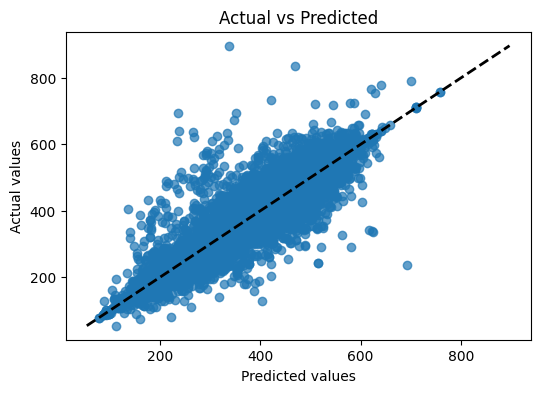

In [16]:
# ACTUAL VS PREDICTED LABEL

y_true = merge_df['Tm'].values
y_pred = oof_val

plt.figure(figsize=(6, 4))

# SCATTER PLOT 2D
plt.scatter(y_pred, y_true, alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Actual vs Predicted')

plt.show()